# Singular

In [1]:
from ipynb.fs.full.koselleck import *
from nltk.corpus import wordnet as wn
from inflex import Noun, Adjective, Verb

In [2]:
# mfwdf=get_corpus().mfw_df()
def get_dfmfw(force=False,**mfw_opts):
    key=str(sorted((k,v) for k,v in mfw_opts.items()))
    with get_db('mfw') as db:
        if key in db: return db[key]
    mfwdf=get_corpus().mfw_df()
    with get_db('mfw','w') as db:
        db[key]=mfwdf
    return mfwdf

In [3]:
def inflect_word_pos(word,pos):
    odx=dict(word=word)
    if pos.startswith('n'):
        obj=odx['obj']=Noun(word)        
        odx['plural']=obj.plural()
        odx['singular']=obj.singular()
    elif pos.startswith('v'):
        obj=odx['obj']=Verb(word)
        odx['plural']=obj.plural()    # Produces "fly"
        odx['singular']=obj.singular()  # Produces "flies"
        odx['past']=obj.past()      # Produces "flew"
        odx['pres_part']=obj.pres_part() # Produces "flying"
        odx['past_part']=obj.past_part() # Produces "flown"
    elif pos.startswith('j'):
        obj=odx['obj']=Adjective(word)
        odx['plural']=obj.plural()    
        odx['singular']=obj.singular()
        odx["comparative"]=obj.comparative() 
        odx["superlative"]=obj.superlative()

    for k in ['plural','singular',
              'past','pres_part','past_part',
              'comparative','superlative']:
        odx['is_'+k]=odx.get('k')==word
        if not k in odx: odx[k]=''
    return odx

In [4]:
from nltk.corpus import wordnet as wn

# Just to make it a bit more readable
WN_NOUN = 'n'
WN_VERB = 'v'
WN_ADJECTIVE = 'a'
WN_ADJECTIVE_SATELLITE = 's'
WN_ADVERB = 'r'

WN_POS=dict(n=WN_NOUN, v=WN_VERB, j=WN_ADJECTIVE)
WN_POSr={
    **dict((v,k) for k,v in WN_POS.items()),
    **{
        WN_ADJECTIVE:'j',
        WN_ADJECTIVE_SATELLITE:'j',
        #WN_ADVERB:'r'
    }
}

def convert_wpos(word, from_pos, to_pos, ntop=2):    
    """ Transform words given from/to POS tags """
    synsets = wn.synsets(word, pos=from_pos)

    # Word not found
    if not synsets:
        return []

    # Get all lemmas of the word (consider 'a'and 's' equivalent)
    lemmas = []
    for s in synsets:
        for l in s.lemmas():
            if s.name().split('.')[1] == from_pos or from_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and s.name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                lemmas += [l]

    # Get related forms
    derivationally_related_forms = [(l, l.derivationally_related_forms()) for l in lemmas]

    # filter only the desired pos (consider 'a' and 's' equivalent)
    related_noun_lemmas = []

    for drf in derivationally_related_forms:
        for l in drf[1]:
            if l.synset().name().split('.')[1] == to_pos or to_pos in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE) and l.synset().name().split('.')[1] in (WN_ADJECTIVE, WN_ADJECTIVE_SATELLITE):
                related_noun_lemmas += [l]

    # Extract the words from the lemmas
    words = [l.name() for l in related_noun_lemmas]
    len_words = len(words)

    # Build the result in the form of a list containing tuples (word, probability)
    result = [(w, float(words.count(w)) / len_words) for w in set(words)]
    result.sort(key=lambda w:-w[1])
    # return all the possibilities sorted by probability
    #print(word, from_pos, to_pos,result)
    result=decide_among_possibilities(word,result)
    result=[(w,round(p,2),round(d,2)) for w,p,d in result]
#     printm(f'* **{word}**, {from_pos} -> {to_pos} = {result}')
    #return '' if not result else result[0][0]
    #print(result)
    return result[:ntop]

def decide_among_possibilities(word,result):
    from strsimpy.levenshtein import Levenshtein
    from strsimpy.normalized_levenshtein import NormalizedLevenshtein
    levenshtein=NormalizedLevenshtein()
    
    result=sorted(
        [
            (w,p,levenshtein.distance(word,w))
            for w,p in result
            if w[:3]==word[:3] # ??
        ],
        key=lambda x: x[2]
    )
    return result


In [5]:
def get_all_pos(word):
    word_synsets = wn.synsets(word)
    o=set()
    for syn in word_synsets:
        for lem in syn.lemmas():
            if lem.name().lower()==word.lower():
                o|={syn.pos()}
    return o

In [6]:
# convert_wpos('wonderfulness','n','n')

In [7]:
def inflect_all_forms(word):
    o=[]
    for pos1_wn in get_all_pos(word):
        pos1=WN_POSr.get(pos1_wn) # wn form
        if not pos1_wn: continue
        for pos2,pos2_wn in WN_POS.items():
            if pos1==pos2: continue
            for (word2,prob2,dist2) in convert_wpos(word,pos1_wn,pos2_wn):
                o+=[dict(
                    form1=word,
                    form2=word2,
                    pos1=pos1,
                    pos2=pos2,
                    prob=prob2,
                    dist=dist2
                )]
    odf=pd.DataFrame(o) if len(o) else pd.DataFrame()
    return odf

In [8]:
# inflect_all_forms('wondrous')

## Cluster words

In [9]:
def cluster_lexemes(idf=None,mfwdf=None,max_size=15,force=True):
    key='_cluster_lexemes_'
    odf=None
    if not force:
        with get_db('mfw','r') as db:
            if key in db: odf=db[key]
    
    if odf is None:
        g=nx.Graph()
        if idf is None: idf=get_valid_words_df(force=True,all_forms=True)
        if mfwdf is None: mfwdf=get_dfmfw()
        w2rank=dict(zip(mfwdf.index, mfwdf['rank']))
        dfg=idf[['form1','form2','pos1','pos2']].dropna()
        for i,row in tqdm(dfg.iterrows(),total=len(dfg),desc='Clustering synsets'):
            n1=f'{row.form1}_{row.pos1}'
            n2=f'{row.form2}_{row.pos2}'
            g.add_edge(n1,n2)

        l=[]
        for i,c in enumerate(sorted(nx.connected_components(g),key=lambda ccx: -len(ccx))):
            wordpos=[(x, x.split('_')[0]) for x in c]
            wordpos.sort(key = lambda x: w2rank.get(x[0],1000000000))
            words = [wp for wp,w in wordpos]
            nouns = [wp for wp,w in wordpos if wp.endswith('_n')]
            if not words: continue
            head = nouns[0] if nouns else words[0]
            for wp,w in wordpos:
                odx=dict(
                    word=w,
                    pos=wp.split('_')[-1],
                    wordpos=wp,
                    head=head,
                    i=i,
                    size=len(c),
                )
                l.append(odx)
    
    odf=pd.DataFrame(l)
    with get_db('mfw','w') as db: db[key]=odf
    if len(odf) and max_size: odf=odf.query(f'size<={max_size}')
    odf=odf.append([
        dict(word='histories',pos='n',wordpos='histories_n',head='history_n'),
    ],ignore_index=True)
    return odf

In [10]:
# dfclust=cluster_lexemes(max_size=15,force=True)
# dfclust

## Comparing forms

In [11]:
dffreq=get_dffreqs()
dffreq_cols=set(dffreq.columns)
# dffreq

In [12]:
def get_freqs_long(words=None,dffreqs=None,rolling=1,key='_long_'):
    with get_db('freqs') as db:
        if key in db: return db[key]
    
    if dffreqs is None: dffreqs=get_dffreqs()
    if words is None: words=get_valid_words()
    words_now = set(words) & set(dffreqs.columns)
    odf=pd.DataFrame(
        dict(word=word, year=year, fpm=fpm)
        for word in tqdm(words_now)
        for year,fpm in dffreqs[word].rolling(rolling).mean().items()
        if not np.isnan(fpm) and fpm>0
    )
    with get_db('freqs','w') as db:
        db[key]=odf
    return odf


In [13]:
# get_freqs_long()

In [14]:
def compare_word_forms(headdf,rolling=10):
    l=[dx for dx in headdf.to_dict('records') if dx['word'] in dffreq_cols]
    odf=pd.DataFrame([
        {**rowd, 'year':y, 'fpm':c}
        for i,rowd in enumerate(l)
        for y,c in dffreq[rowd['word']].rolling(rolling).mean().items()
    ])
    odf=pd.concat(
        g.assign(rel_perc=g.fpm / g.fpm.sum() * 100)
        for i,g in odf.groupby('year')
    ) if len(odf) else pd.DataFrame()

In [15]:
def get_wordform_cluster(w_or_wdf,rolling=1,all_data=False):
    if type(w_or_wdf)==str:
        dfclust=cluster_lexemes() if not all_data else get_valid_words_df().reset_index()
        wdf=dfclust[dfclust['word']==w_or_wdf.lower()]
    else:
        wdf=w_or_wdf
    if not len(wdf): return pd.DataFrame()
    head=wdf.iloc[0]['head']
    headdf=dfclust[dfclust['head']==head]
    odf=compare_word_forms(headdf,rolling=rolling)
    return odf

In [16]:
def order_pos_within_cluster(word_or_wdf,y='fpm',ymin=YMIN_DISTMAT,ymax=YMAX_DISTMAT):
    if type(word_or_wdf)==str:
        wdf=get_wordform_cluster(word_or_wdf,all_data=False).query(f'{ymin}<=year<{ymax}')
    else:
        wdf=word_or_wdf
    #wdf['year_fpm']=wdf['year'] * wdf['fpm']
    if wdf is None or not len(wdf): return pd.DataFrame()
    pgrps=wdf.groupby(['wordpos'])
    l=[]
    for (wpos1),posdf1 in pgrps:
        odx={'wordpos':wpos1}
        s1=posdf1[['year',y]].groupby('year').mean().sort_index()[y].fillna(0)
        y1avg=np.average(s1.index, weights=s1)
        odx['pos_year_avg']=y1avg
        l+=[odx]
    odf=pd.DataFrame(l)
    odf['pos_year_rank']=odf['pos_year_avg'].rank().apply(int)
    return odf.sort_values('pos_year_rank')

In [17]:
# odf=order_pos_within_cluster('modest')
# odf

In [18]:
# order_pos_within_cluster('value')

In [19]:
def get_year_avg(w,dffreqs=None):
    if dffreqs is None: dffreqs=get_dffreqs()
    if not w in set(dffreqs.columns): return np.nan
    s=dffreqs[w].dropna()
    return np.average(s.index, weights=s)


In [20]:
# get_year_avg('value')

In [21]:
def get_valid_words_df(mfwdf=None,force=False,key_cache='_valid_',all_forms=True):
    odf=None
    with get_db('wpos','c') as db:
        if not force and key_cache in db: 
            odf=db[key_cache]
        else:
            if mfwdf is None: mfwdf=get_dfmfw()
            vwl=get_valid_words()
            odf=mfwdf.loc[vwl].join(
                pd.DataFrame(
                    db.get(w,{}) for w in tqdm(vwl,desc='Loading lemma data')
                ).set_index('word'),
                rsuffix='_wpos'
            )
            odf=odf.join(
                pd.DataFrame(
                    inflect_word_pos(w,pos)
                    for w,pos in tqdm(
                        zip(odf.index, odf.pos),
                        total=len(odf),
                        desc='Inflecting words',
                    )
                ).set_index('word')
            )
            odf2=pd.concat([inflect_all_forms(w) for w in tqdm(odf.index,'Inflecting all forms')])

            odf=odf.reset_index().merge(
                odf2,
                left_on='word',
                right_on='form1',
                how='outer'
            )
            
            dfclust=cluster_lexemes(odf,force=force)
            odf=odf.merge(
                dfclust,
                left_on=['word','pos0'],
                right_on=['word','pos'],
                suffixes=['','_lex'],
                how='outer'
            )
            
            dffreqs=get_dffreqs()
            odf['year_avg_pos']=[get_year_avg(w,dffreqs) for w in tqdm(odf.word)]
            odf=pd.concat(
                g.assign(
                    head_year_rank=g.year_avg_pos.rank(method='min')
                )
                for i,g in tqdm(odf.groupby('head'))
            )
            #odf
            
            
            odf=odf.drop_duplicates(
                ['word','pos0','form1','form2','pos1','pos2','wordpos','head','pos']
            )            
            with get_db('wpos','w') as db: db[key_cache]=odf

    if not all_forms:
        odf=odf.drop_duplicates('word')
    return odf


# odf=get_valid_words_df(force=True)
odf=get_valid_words_df(force=False,all_forms=True)
odf

,word,count,fpm,rank,ranks_avg,pos,pos0,lemma,pos_wpos,rank_wpos,...,pos2,prob,dist,pos_lex,wordpos,head,i,size,year_avg_pos,head_year_rank
7780,abandon,40836.0,11.834470,6097.0,6097.0,vv0,v,abandon,vv0,6691.0,...,n,0.44,0.36,v,abandon_v,abandonment_n,3341.0,2.0,1812.663969,1.0
14943,abandonment,13990.0,4.054370,13300.0,13300.0,nn1,n,abandonment,nn1,13553.0,...,v,0.57,0.36,n,abandonment_n,abandonment_n,3341.0,2.0,1872.911046,2.0
20066,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,n,0.25,0.33,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
20067,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,n,0.25,0.44,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
20068,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,j,1.00,0.38,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,zone,13364.0,3.872952,13753.0,13753.0,nn1,n,zone,nn1,2420.0,...,n,0.33,0.00,n,zone_n,zone_n,2285.0,3.0,1856.213048,1.0
29303,zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,v,zone_v,zone_n,2285.0,3.0,1856.213048,1.0
29304,zonary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,j,zonary_j,zone_n,2285.0,3.0,NaN,NaN
13572,zoological,16691.0,4.837132,11802.0,11802.0,jj,j,zoological,jj,32348.0,...,n,1.00,0.40,j,zoological_j,zoology_n,3841.0,2.0,1873.667239,2.0


## Rank appearances

In [22]:
# by pos

In [23]:
vwdf=get_valid_words_df()
vwdf

,word,count,fpm,rank,ranks_avg,pos,pos0,lemma,pos_wpos,rank_wpos,...,pos2,prob,dist,pos_lex,wordpos,head,i,size,year_avg_pos,head_year_rank
7780,abandon,40836.0,11.834470,6097.0,6097.0,vv0,v,abandon,vv0,6691.0,...,n,0.44,0.36,v,abandon_v,abandonment_n,3341.0,2.0,1812.663969,1.0
14943,abandonment,13990.0,4.054370,13300.0,13300.0,nn1,n,abandonment,nn1,13553.0,...,v,0.57,0.36,n,abandonment_n,abandonment_n,3341.0,2.0,1872.911046,2.0
20066,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,n,0.25,0.33,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
20067,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,n,0.25,0.44,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
20068,abate,7894.0,2.287719,19522.0,19522.0,vv0,v,abate,vv0,32217.0,...,j,1.00,0.38,v,abate_v,abator_n,1283.0,4.0,1765.974854,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,zone,13364.0,3.872952,13753.0,13753.0,nn1,n,zone,nn1,2420.0,...,n,0.33,0.00,n,zone_n,zone_n,2285.0,3.0,1856.213048,1.0
29303,zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,v,zone_v,zone_n,2285.0,3.0,1856.213048,1.0
29304,zonary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,j,zonary_j,zone_n,2285.0,3.0,NaN,NaN
13572,zoological,16691.0,4.837132,11802.0,11802.0,jj,j,zoological,jj,32348.0,...,n,1.00,0.40,j,zoological_j,zoology_n,3841.0,2.0,1873.667239,2.0


In [24]:
vwdf.groupby('pos_wpos').mean().sort_values('year_avg_pos')

,count,fpm,rank,ranks_avg,rank_wpos,perc_caps,prob,dist,i,size,year_avg_pos,head_year_rank
pos_wpos,,,,,,,,,,,,
vvd,187051.363636,54.208389,5665.000000,5665.000000,13318.545455,0.036364,0.328182,0.138182,1059.545455,3.818182,1811.092334,1.000000
vv0,57226.194701,16.584428,10608.492851,10608.499159,14766.263667,0.074239,0.369453,0.245913,1237.852397,4.684609,1820.846876,1.713204
vvn,130271.500000,37.753310,12968.875000,12970.375000,13300.000000,0.028750,0.306250,0.232500,850.875000,4.625000,1830.070909,3.375000
nn2,81019.969925,23.479979,8041.172932,8041.154135,11119.075188,0.122895,0.608679,0.263358,824.966038,5.384906,1835.762114,3.676692
nn1,76932.385886,22.295377,9660.921233,9660.918909,13477.221624,0.140963,0.572608,0.197247,1629.777764,4.206703,1837.859951,2.352711
jj,73122.825407,21.191348,10769.052777,10769.063823,15508.829089,0.085827,0.550181,0.280264,1816.085609,3.987419,1843.452589,2.493850
jjr,162544.750000,47.106254,3632.916667,3632.916667,2330.000000,0.040000,0.328333,0.383333,952.666667,4.083333,1856.586455,5.250000
jjt,98844.250000,28.645541,3092.000000,3092.000000,4366.750000,0.010000,0.557500,0.395000,845.500000,4.000000,1867.789702,4.000000


In [25]:
def _assign_rel_perc_word_(g):
    return g.assign(rel_perc_word=g.fpm / g.fpm.sum() * 100)


def iter_freqs_long_pos(lim=None,force=False,key='_long_pos_',num_proc=1):
    if not force:
        with get_db('freqs_root') as db:
            keys=list(db.keys())
            for k in tqdm(keys): yield db[k]
    else:
        longfreqs = get_freqs_long()
        biginfo = get_valid_words_df()
        biglong=longfreqs.merge(
            biginfo[['word','wordpos','pos','pos_wpos','pos_lex','head']],
            on='word',
            suffixes=['_yr','']
        ).drop_duplicates(['word','year','wordpos'])
        odf=biglong.iloc[:lim].groupby(['year']).progress_apply(
            lambda g: g.assign(rel_perc_year=g.fpm / g.fpm.sum() * 100)
        ).reset_index(drop=True)
        with get_db('freqs_root','w') as db:
            for w,wdf in tqdm(odf.groupby('head')):
                wl=[]
                for y,ydf in wdf.groupby('year'):
                    ydf['rel_perc_word']=ydf.fpm / ydf.fpm.sum() * 100
                    wl+=[ydf]
                owdf=pd.concat(wl)
                db[w]=owdf
                yield owdf
                
DFFREQSLONGPOS=None
def get_freqs_long_pos(force=False,key='_long_pos_',**y):
    global DFFREQSLONGPOS
    if not force:
        if DFFREQSLONGPOS is not None: return DFFREQSLONGPOS
        with get_db('freqs') as db:
            if key in db: 
                DFFREQSLONGPOS=db[key]
                return DFFREQSLONGPOS
    odf=pd.concat(x for x in iter_freqs_long_pos(**y) if type(x)==pd.DataFrame)
    odf=odf.merge(
        get_valid_words_df()[['wordpos','size','year_avg_pos','head_year_rank']],
        on='wordpos'
    )
    with get_db('freqs','w') as db: db[key]=odf
    DFFREQSLONGPOS=odf
    return odf

In [27]:
# %%timeit
# get_freqs_long_pos(force)

## Plots

In [28]:
df=get_freqs_long_pos(force=True)
df

100%|██████████| 4804/4804 [00:03<00:00, 1237.46it/s]


,word,year,fpm,wordpos,pos,pos_wpos,pos_lex,head,rel_perc_year,rel_perc_word,size,year_avg_pos,head_year_rank
0,abandon,1681,133.846411,abandon_v,vv0,vv0,v,abandonment_n,0.013346,100.000000,2.0,1812.663969,1.0
1,abandon,1682,25.161664,abandon_v,vv0,vv0,v,abandonment_n,0.002550,100.000000,2.0,1812.663969,1.0
2,abandon,1683,48.192771,abandon_v,vv0,vv0,v,abandonment_n,0.004707,100.000000,2.0,1812.663969,1.0
3,abandon,1684,59.347181,abandon_v,vv0,vv0,v,abandonment_n,0.005581,100.000000,2.0,1812.663969,1.0
4,abandon,1686,104.515050,abandon_v,vv0,vv0,v,abandonment_n,0.009606,100.000000,2.0,1812.663969,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4317076,zoological,1960,18.125245,zoological_j,jj,jj,j,zoology_n,0.001895,54.545455,2.0,1873.667239,2.0
4317077,zoological,1961,2.965019,zoological_j,jj,jj,j,zoology_n,0.000310,50.000000,2.0,1873.667239,2.0
4317078,zoological,1963,3.125606,zoological_j,jj,jj,j,zoology_n,0.000324,100.000000,2.0,1873.667239,2.0
4317079,zoological,1964,7.286797,zoological_j,jj,jj,j,zoology_n,0.000763,66.666667,2.0,1873.667239,2.0


### Pos wars

In [29]:
# tbldf=get_freqs_long_pos().groupby('pos').mean().sort_values('year_avg_pos')
# tbldf

In [30]:
VALCOLS_SING=['fpm_perc_year','fpm',
            'rel_perc_year','rel_perc_word','head_year_rank','year_avg_pos']
GBY_SING=['pos','year','pos_lex']

In [31]:
posdf=get_freqs_long_pos()
figdf=posdf.groupby(GBY_SING).sum().sort_index().reset_index()
figdf=pd.concat(
    g.assign(fpm_perc_year=(g.fpm / g.fpm.sum())*100)
    for i,g in figdf.groupby('year')
)
figdf_m=figdf.melt(id_vars=GBY_SING)
figdf_m=pd.concat(
    g.assign(value_z=(g.value - g.value.mean())/g.value.std())
    for i,g in figdf_m.groupby(['variable','pos'])
)
figdf_m

,pos,year,pos_lex,variable,value,value_z
0,jj,1681,j,fpm,254843.567007,-1.527224
7,jj,1682,j,fpm,268550.436555,-1.033877
14,jj,1683,j,fpm,244771.084337,-1.889759
22,jj,1684,j,fpm,252047.477745,-1.627862
29,jj,1685,j,fpm,262758.549007,-1.242342
...,...,...,...,...,...,...
11447,vvn,1967,v,year_avg_pos,7212.440232,-1.753053
11455,vvn,1968,v,year_avg_pos,7212.440232,-1.753053
11463,vvn,1969,v,year_avg_pos,7212.440232,-1.753053
11471,vvn,1970,v,year_avg_pos,14640.567275,0.552026


In [165]:

@interact
def draw(y=VALCOLS_SING,z=False,facet=True):
    fdf=figdf_m[figdf_m.variable==y]
    fdf['pos']=pd.Categorical(
        fdf['pos'],
        categories=fdf.groupby('pos').sum().reset_index().sort_values(
            'value',ascending=False).pos.unique()
    )
    fig=start_fig(
        fdf,
        x='year',
        y='value' if not z else 'value_z',
        color='pos',
#         shape='pos_lex',
        theme='classic'
    )
    fig+=p9.geom_point(size=.5)
    fig+=p9.geom_smooth(se=True)
    if facet: fig+=p9.facet_wrap('pos',scales='free_y')
    fig+=p9.scale_color_gray()
    return fig

interactive(children=(Dropdown(description='y', options=('fpm_perc_year', 'fpm', 'rel_perc_year', 'rel_perc_wo…

In [172]:
#posdf=get_freqs_long_pos()
posdf[posdf['pos']=='vv0'].sample(n=10)

,word,year,fpm,wordpos,pos,pos_wpos,pos_lex,head,rel_perc_year,rel_perc_word,size,year_avg_pos,head_year_rank
4076259,undertake,1847,94.105541,undertake_v,vv0,vv0,v,undertaking_n,0.010401,54.804270,2.0,1805.698550,2.0
3345755,satisfy,1969,89.120886,satisfy_v,vv0,vv0,v,satisfactoriness_n,0.008558,22.580645,5.0,1819.995845,1.0
2465049,mow,1761,23.728226,mow_v,vv0,vv0,v,mower_n,0.002606,50.000000,3.0,1791.497276,1.0
2871436,precipitate,1841,11.932376,precipitate_v,vv0,vv0,v,precipitousness_n,0.001310,14.163090,10.0,1794.611995,1.0
1983453,impress,1891,45.506708,impress_v,vv0,vv0,v,impress_n,0.004959,11.573850,7.0,1848.234779,1.0
1257640,drain,1715,47.323837,drain_v,vv0,vv0,v,drainage_n,0.004906,50.000000,3.0,1847.976730,1.0
3212624,restore,1863,80.256341,restore_v,vv0,vv0,v,restitution_n,0.008783,37.985310,6.0,1802.969632,3.0
1496472,fathom,1706,10.302269,fathom_v,vv0,vv0,v,fathom_n,0.001098,50.000000,2.0,1798.019470,1.0
1434601,explain,1847,143.602611,explain_v,vv0,vv0,v,explication_n,0.015872,43.761639,4.0,1808.016481,1.0
2895460,prescribe,1729,29.693562,prescribe_v,vv0,vv0,v,prescription_n,0.003346,75.000000,3.0,1767.675489,1.0


## Average POS

In [174]:
posavg=posdf.groupby('pos').mean()
posavg

,year,fpm,rel_perc_year,rel_perc_word,size,year_avg_pos,head_year_rank
pos,,,,,,,
jj,1841.303588,108.841476,0.011674,55.112299,3.988454,1839.964991,2.421200
jjr,1831.973518,207.720426,0.022231,22.754986,4.091484,1856.154253,5.283479
jjt,1839.514259,110.509999,0.011831,12.042207,4.030418,1867.324558,4.062738
nn1,1837.997407,121.457757,0.013011,46.200908,4.229462,1834.657864,2.295825
nn2,1836.038141,124.066761,0.013305,28.369100,5.447777,1833.764432,3.680836
vv0,1834.875360,93.647560,0.010029,45.245085,4.704805,1819.280897,1.698214
vvd,1831.060956,285.577934,0.030678,42.997039,3.754201,1810.451703,1.000000
vvn,1839.161243,208.808427,0.022392,42.362200,4.575444,1826.508036,3.160256


,word,year,fpm,wordpos,pos,pos_wpos,pos_lex,head,rel_perc_year,rel_perc_word,size,year_avg_pos,head_year_rank
0,abandon,1681,133.846411,abandon_v,vv0,vv0,v,abandonment_n,0.013346,100.000000,2.0,1812.663969,1.0
279,abandonment,1774,2.600090,abandonment_n,nn1,nn1,n,abandonment_n,0.000279,5.555556,2.0,1872.911046,2.0
458,abate,1683,96.385542,abate_v,vv0,vv0,v,abatement_n,0.009415,100.000000,4.0,1765.974854,1.0
1238,abatement,1686,52.257525,abatement_n,nn1,nn1,n,abatement_n,0.004803,100.000000,4.0,1793.263824,4.0
1476,abbey,1682,25.161664,abbey_n,nn1,nn1,n,abbess_n,0.002550,100.000000,4.0,1845.784036,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314382,zenith,1682,25.161664,zenith_n,nn1,nn1,n,zenith_n,0.002550,100.000000,2.0,1825.081532,1.0
4314621,zest,1707,15.501953,zest_n,nn1,nn1,n,zest_n,0.001590,50.000000,4.0,1899.467891,1.0
4315716,zone,1682,25.161664,zone_n,nn1,nn1,n,zone_n,0.002550,50.000000,3.0,1856.213048,1.0
4316724,zoology,1733,3.155052,zoology_n,nn1,nn1,n,zoology_n,0.000345,100.000000,2.0,1852.731269,1.0


In [237]:
def plot_posavg(posdf,y='year_avg_pos'):
    figdf=posdf.drop_duplicates('word')
    figdf=figdf[~figdf.pos.isna()]
    figdf=figdf.groupby('pos').filter(lambda g: len(g)>=25)
    figdf['pos']=pd.Categorical(
        figdf['pos'],
        categories=figdf.groupby('pos').median().sort_values(y,ascending=False).index
    )
    figdf=pd.concat(
        g.assign(
            ymin=g[y].median()-(g[y].std()/2),
            ymax=g[y].median()+(g[y].std()/2)
        )
        for i,g in figdf.groupby('pos')
    )
    fig=start_fig(
        figdf,
        x='pos',
        y=y,
        group='pos'
    )
    fig+=p9.geom_violin()
    fig+=p9.geom_point(size=.25,alpha=.5)
    fig+=p9.geom_point(
        #p9.aes(ymin='ymin',ymax='ymax'),
        data=figdf.groupby('pos').median().reset_index(),
        size=.5,
#         fatten=1
    )
    fig+=p9.coord_flip()
    
    return fig

In [239]:
# plot_posavg(posdf)

In [314]:
def plot_posavg_density(posdf,y='year_avg_pos'):
    figdf=posdf.drop_duplicates('word')
    figdf=figdf[~figdf.pos.isna()]
    figdf=figdf.groupby('pos').filter(lambda g: len(g)>=25)
    cats=list(figdf.groupby('pos').mean().sort_values(y,ascending=True).index)
    figdf['pos']=pd.Categorical(
        figdf['pos'],
        categories=cats
    )
    figdf=figdf#.groupby('pos')#.sample(n=100)
    fig=start_fig(
        figdf,
        x=y,
        y='..density..',
        group='pos',
        color='pos',
        linetype='pos',
        figure_size=(8,6),
        theme='classic'
    )
    fig+=p9.geom_density(size=1)
    fig+=p9.scale_color_gray()
    fig+=p9.geom_vline(
        p9.aes(xintercept=y,linetype='pos',color='pos'),
        size=.5,
        data=figdf.groupby('pos').median().reset_index()
    )
#     figdf['ylbl']=-1#[((len(cats)-cats.index(pos))+1)*2 for pos in figdf.pos]
#     lbldf=figdf.groupby('pos').median().reset_index()
#     lbldf[y]+=5
#     fig+=p9.geom_text(
#         p9.aes(label='pos',y='ylbl'),
#         size=7,
#         color='#000000',
#         angle=90,
#         data=lbldf
#     )
    fig+=p9.facet_wrap('pos',ncol=1)
    return fig

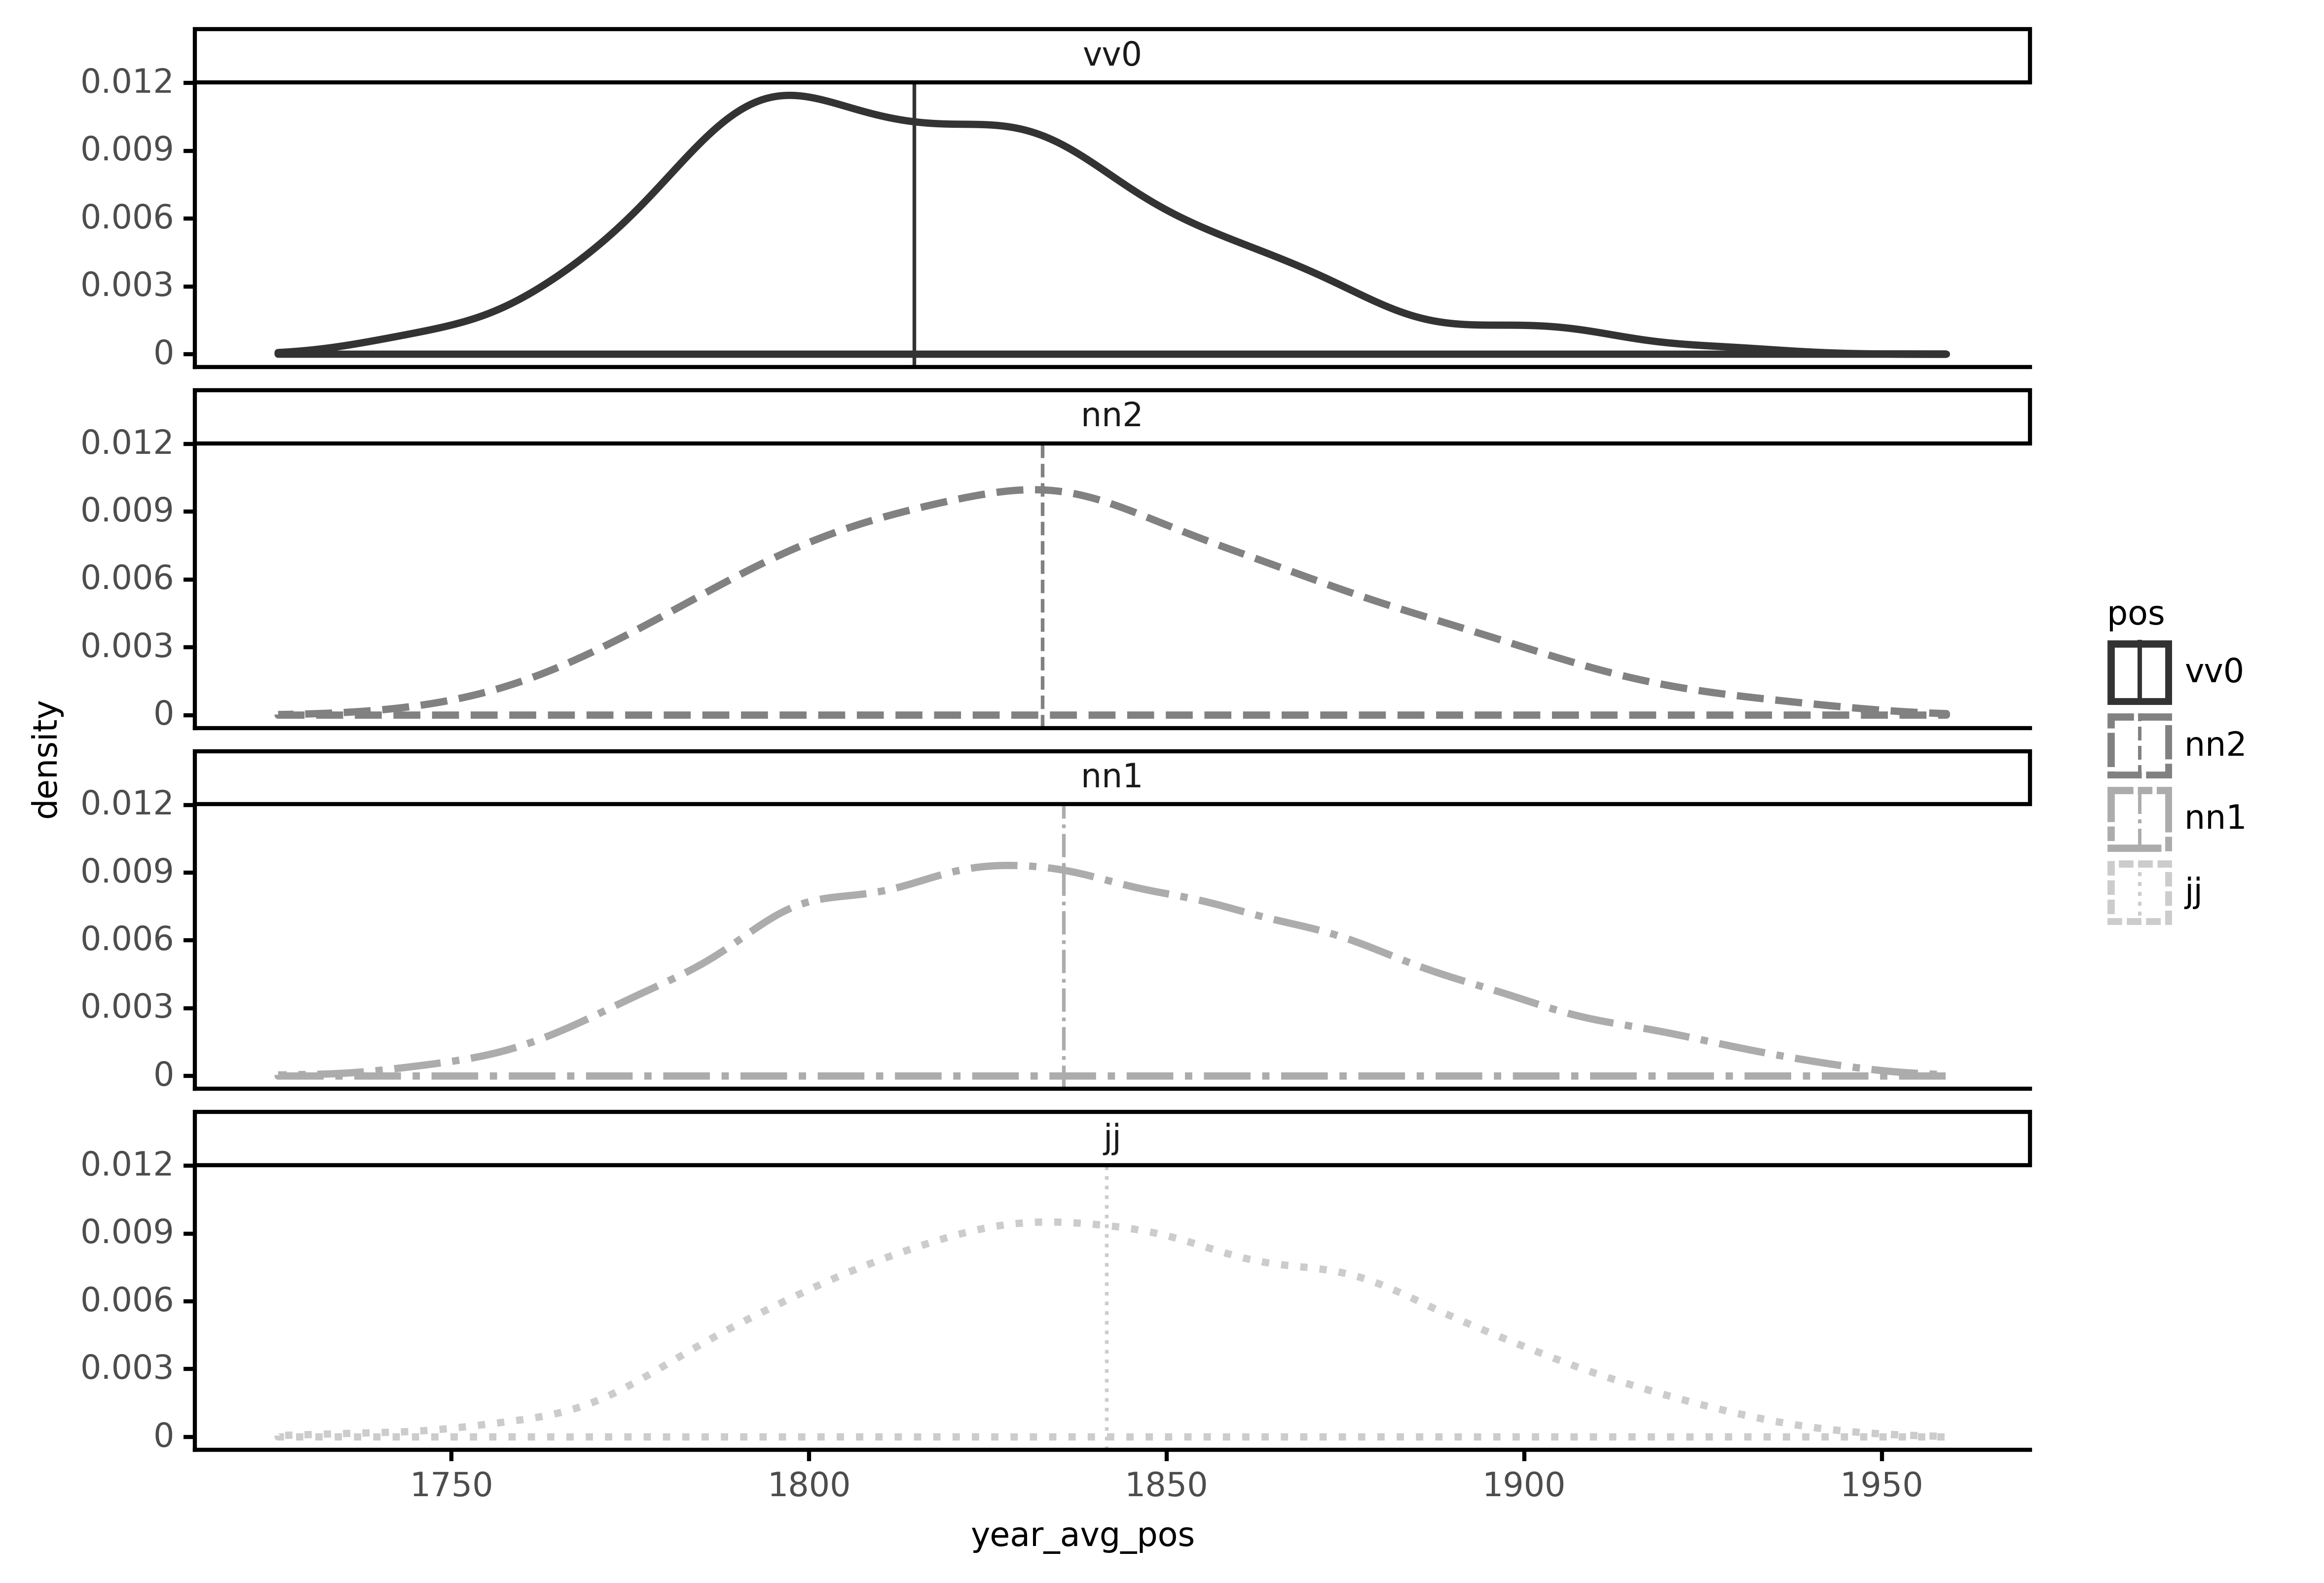

<ggplot: (8730496275908)>

In [315]:
plot_posavg_density(posdf)

In [334]:
def get_ranksums_pos(dfpos):
    from scipy.stats import ranksums
    posdf=dfpos.drop_duplicates('word').groupby('pos').filter(lambda g: len(g)>=25)
    l=[]
    for pos1,pdf1 in tqdm(posdf.groupby('pos')):
        for pos2,pdf2 in posdf.groupby('pos'):
            if pos1>=pos2: continue
            odx=dict(pos1=pos1,pos2=pos2)
            odx['coeff'],odx['p'] = ranksums(pdf1.year_avg_pos, pdf2.year_avg_pos)#, alternative='greater')
            l.append(odx)
    odf=pd.DataFrame(l).sort_values('coeff')
    odf['coeff_rank']=odf['coeff'].rank(ascending=False,method='min')
    odf['coeff_abs']=odf['coeff'].apply(abs)
    odf['coeff_abs_rank']=odf['coeff_abs'].rank(ascending=False,method='min')
    odf=odf.sort_values(['coeff_rank'])
    return odf

In [335]:
round(get_ranksums_pos(posdf),2)

100%|██████████| 4/4 [00:00<00:00, 389.52it/s]


,pos1,pos2,coeff,p,coeff_rank,coeff_abs,coeff_abs_rank
2,jj,vv0,15.73,0.00,1.0,15.73,1.0
4,nn1,vv0,13.60,0.00,2.0,13.60,2.0
5,nn2,vv0,5.55,0.00,3.0,5.55,3.0
0,jj,nn1,4.43,0.00,4.0,4.43,4.0
1,jj,nn2,2.55,0.01,5.0,2.55,5.0
3,nn1,nn2,0.87,0.38,6.0,0.87,6.0


### Plot individual words

In [36]:
def get_head(w):
    dff=get_freqs_long_pos().query(f'word=="{w}"')
    if not len(dff): return ''
    return dff.iloc[0]['head']

In [163]:
def plot_form_change_both(w,odf=None,rolling=2,returndata=False,ybin=YBIN_DISTMAT):
    iby=['word','pos','wordpos','head','year']
    
    if odf is None:
        odf=get_freqs_long_pos().query(f'head=="{get_head(w)}"')
    odf['year']=[y//ybin*ybin for y in odf['year']]
    odf=odf.groupby(iby).mean().reset_index()
    odf=pd.concat(
        g.assign(
            rel_perc_word=g.fpm / g.fpm.sum()# * 100
        ) for i,g in odf.groupby(['year'])
    )
    
    numcols=[c for c in odf.select_dtypes('number').columns if not c in set(iby)]
    odf=odf[iby+numcols]
    
    figdf=odf.melt(id_vars=iby)
    
    figdf['word']=pd.Categorical(
        figdf['word'],
        categories=figdf.groupby('word').sum().value.sort_values(ascending=False).index
    )
    figdf=figdf[figdf.variable.isin({'fpm','rel_perc_word'})]
    figdf=pd.concat(
        g.assign(
            value=(
                g.value.rolling(rolling).mean()
                if v=='fpm'
                else g.value
            )   
        ) for (wp,v),g in figdf.groupby(['wordpos','variable'])
    )
    
    figdf=pd.concat(
        g.assign(
            year_max=g[g.value==g.value.max()].iloc[0].year,
            year_min=g[g.value==g.value.min()].iloc[0].year,
            value_max=g.value.max(),
            value_min=g.value.min(),
            value_last=g.value.iloc[-1],
            year_last=g.year.iloc[-1],
        )
        for i,g in figdf.groupby(['wordpos','variable'])
    )
    if returndata: return figdf
    
    
    labeldf=figdf[figdf.variable=='rel_perc_word'].groupby(
        ['wordpos','variable']
    ).median().reset_index()
    
    labeldf_line=figdf.groupby('wordpos').head(1)
    
    fig=start_fig(
        figdf,
        x='year',
        group='wordpos',
        figure_size=(8,5),
        theme='classic'
    )
    fig+=p9.facet_wrap('variable',scales='free_y')
    fig+=p9.geom_area(
        p9.aes(color='wordpos',y='value',fill='wordpos'),
        data=figdf[figdf.variable=='rel_perc_word'],
        size=1,alpha=.1,
    )
#     fig+=p9.geom_bar(
#         p9.aes(fill='wordpos'),
#         data=figdf[figdf.variable=='rel_perc_word'],
#         size=1,alpha=1#,fill='#eeeeee'
#     )
    fig+=p9.geom_line(
        p9.aes(color='wordpos',y='value'),
        data=figdf[figdf.variable!='rel_perc_word'],
        size=1,alpha=1
    )
#     fig+=p9.geom_point(
#         p9.aes(color='wordpos',shape='pos'),
#         data=figdf[figdf.variable!='rel_perc'],
#         size=1,alpha=.5
#     )
#     fig+=p9.geom_text(
#         p9.aes(label='wordpos',x='year_last',y='value_last'),
#         data=labeldf_line,
#         size=8
#     )
    fig+=p9.geom_text(
        p9.aes(label='wordpos',x='year_max',y='value_max'),
        data=labeldf_line,
        size=8
    )
    fig+=p9.geom_text(
        p9.aes(label='wordpos',y='value'),
        data=labeldf,
        position=p9.position_stack(vjust=.75),
        size=8,
    )
    fig+=p9.scale_fill_gray()#brewer()
    fig+=p9.scale_color_gray()#brewer()
    return fig


In [164]:
@interact
def iplot_form_change_both(w='value',rolling=2,ybin=YBIN_DISTMAT):
    try:
        return plot_form_change_both(w,rolling=rolling,ybin=ybin)
    except ValueError:
        return

interactive(children=(Text(value='value', description='w'), IntSlider(value=2, description='rolling', max=6, m…